# Course Project

### Load Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [31]:
plt.rcParams['figure.figsize'] = [16, 12]

### Load Datasets

In [32]:
train_df = pd.read_csv('course_project_train.csv')
test_df = pd.read_csv('course_project_test.csv')

### Data Checking

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [34]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [36]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


### Data Processing

In [37]:
def mis_values_report(df):
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Lost values', 1: '% from all values'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% from all values', ascending=False).round(1)
    print('Dataset has ' + str(df.shape[1]) + ' columns.\n' + str(report_columns.shape[0]) + ' columns have lost values')
    return report_columns

In [38]:
mis_values_report(train_df)

Dataset has 17 columns.
5 columns have lost values


,Lost values,% from all values
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


##### Change more often lost values

In [39]:
train_df['Months since last delinquent'].fillna(float(0), inplace = True)

In [40]:
train_df['Bankruptcies'].fillna(float(0), inplace = True)

In [41]:
mis_values_report(train_df)

Dataset has 17 columns.
3 columns have lost values


,Lost values,% from all values
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9


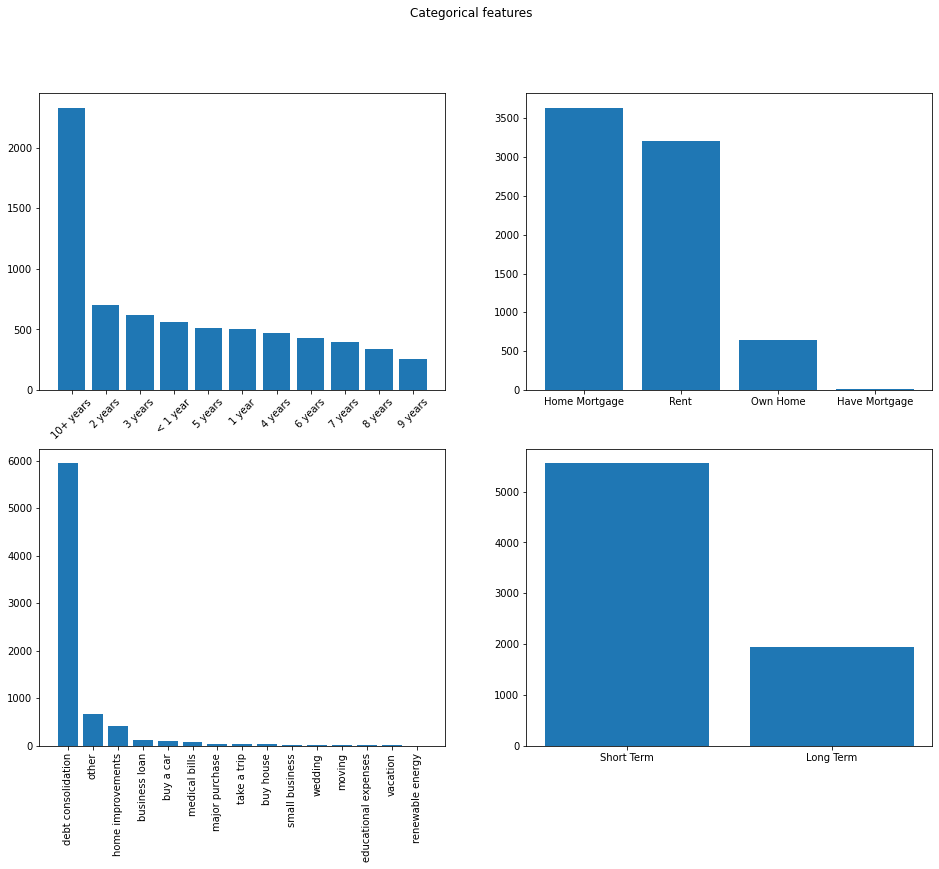

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.bar(train_df['Years in current job'].value_counts().index, train_df['Years in current job'].value_counts().values)
ax2.bar(train_df['Home Ownership'].value_counts().index, train_df['Home Ownership'].value_counts().values)
ax3.bar(train_df['Purpose'].value_counts().index, train_df['Purpose'].value_counts().values)
ax4.bar(train_df['Term'].value_counts().index, train_df['Term'].value_counts().values)

fig.suptitle('Categorical features')
ax1.xaxis.set_tick_params(rotation=45)
ax3.xaxis.set_tick_params(rotation=90)

In [43]:
purpose_cr_deafult = train_df[['Purpose','Credit Default']]
purpose_cr_deafult.head()

,Purpose,Credit Default
0,debt consolidation,0
1,debt consolidation,1
2,debt consolidation,0
3,debt consolidation,0
4,debt consolidation,0


<AxesSubplot:title={'center':'Purpose  Vs Credit Default'}, xlabel='Purpose'>

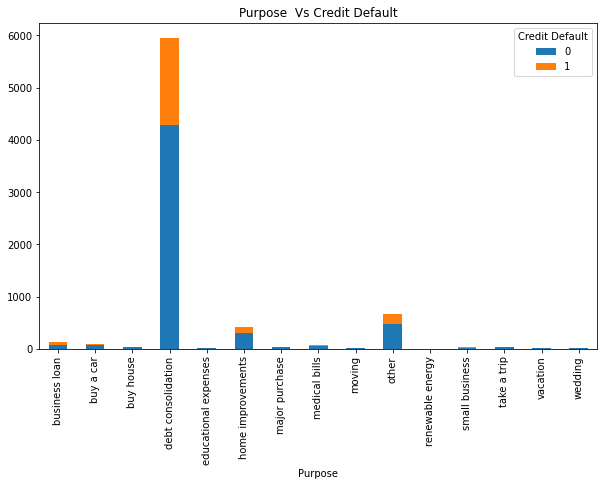

In [44]:
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot(kind='bar', stacked=True, figsize=(10,6), title="Purpose  Vs Credit Default", )

##### Main count of creditors are mortgagees or tenants

### Class balance

In [45]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [46]:
test_df['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

##### We don't have any new variants

In [47]:
train_df['Years in current job'] = train_mod['Years in current job'].fillna('0').map({'0': 0, '< 1 year': 1, '1 year': 2, '2 years': 3,
                                                                                       '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, 
                                                                                       '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11})
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,NaN,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,NaN,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,NaN,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,NaN,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [48]:
train_df.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = train_df.loc[:, ['Months since last delinquent', 
                                                                                                       'Bankruptcies', 'Credit Score']].fillna(value=0)
train_df['Annual Income'].fillna(value=train_df['Annual Income'].mean(), inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          0 non-null      float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##### We will use CatBoost, because:
    We have a lot of categorical features
    CatBoost work in practice better than any other classical models on linearly inseparable problems

In [49]:
categorical_features_indices = np.where((train_df.dtypes == object))[0]
categorical_features_names = train_df.iloc[:, list(np.where(train_df.dtypes == object)[0])].columns

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('Credit Default', axis=1), 
        train_df['Credit Default'], train_size=0.75, random_state=42)

In [51]:
class ClassifierObjective(object):
    def __init__(self, trainset, validset, const_params):
        self.train_dataset = trainset
        self.valid_dataset = validset
        self._const_params = const_params.copy()
        
    def _to_catboost_params(self, hyper_params):
        return {'iterations': int(hyper_params['iterations']),
                'learning_rate': hyper_params['learning_rate'],
                'depth': hyper_params['depth'],
                'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('\nEvaluating with params={}'.format(params))
        
        clf = CatBoostClassifier(**params)
        clf.fit(self.train_dataset, eval_set=self.valid_dataset, use_best_model=True)
        preds = clf.predict(self.valid_dataset)
        
        score = f1_score(self.valid_dataset.get_label(), preds)
        print('\nevaluated score={}'.format(score))
        
        return {'loss': 1-score, 'status': STATUS_OK}

In [52]:
def find_best_hyper_params(trainset, validset, const_params, max_evals=100):    
    parameter_space = {'iterations': hp.randint('iterations', 1500),
                       'learning_rate': hp.uniform('learning_rate', 0.2, 1.0),
                       'depth': hp.randint('depth', 15),
                       'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)}
    objective = ClassifierObjective(trainset, validset, const_params=const_params)
    trials = Trials()
    best = fmin(fn=objective, space=parameter_space, algo=tpe.suggest, max_evals=max_evals)
    return best

In [53]:
def train_best_model(X_tr, y_tr, X_val, y_val, X_all, y_all, const_params, cat_features, max_evals=100):
    trainset = Pool(X_tr, y_tr, cat_features=cat_features)
    validset = Pool(X_val, y_val, cat_features=cat_features)
    dataset = Pool(X_all, y_all, cat_features=cat_features)
    
    best = find_best_hyper_params(trainset, validset, const_params, max_evals=max_evals)
  
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    model = CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [54]:
w = train_df['Credit Default'].value_counts()[0] / train_df['Credit Default'].value_counts()[1]
const_params = dict({'task_type': 'CPU',
                    'loss_function': 'Logloss',
                    'eval_metric': 'F1', 
                    'custom_metric': ['F1'],
                    'class_weights': [1, w],
                    'verbose': 200})

In [55]:
model, params = train_best_model(X_train, y_train, X_valid, y_valid,
                                 train_df.drop('Credit Default', axis=1), train_mod['Credit Default'],
                                 const_params, categorical_features_indices, max_evals=50)
print('best params are {}'.format(params))

                                                                                                                       
Evaluating with params={'iterations': 1477, 'learning_rate': 0.9641722049628774, 'depth': 9, 'l2_leaf_reg': 2.3097908191147516, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.6117289	test: 0.6214937	best: 0.6214937 (0)	total: 36.4ms	remaining: 53.8s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

200:	learn: 1.0000000	test: 0.5633777	best: 0.6440375 (5)	total: 7.06s	remaining: 44.8s
400:	learn: 1.0000000	test: 0.5650917	best: 0.6440375 (5)	total: 13.9s	remaining: 37.3s
600:	learn: 1.0000000	test: 0.5635000	best: 0.6440375 (5)	total: 20.8s	remaining: 30.3s
800:	learn: 1.0000000	test: 0.5633771	best: 0.6440375 (5)	total: 27.7s	remaining: 23.4s
1000:	learn: 1.0000000	test: 0.5617758	best: 0.6440375 (5)	total: 34.6s	remaining: 16.5s
1200:	learn: 1.0000000	test: 0.5633771	best: 0.6440375 (5)	total: 41.4s	remaining: 9.51s
1400:	learn: 1.0000000	test: 0.5620216	best: 0.6440375 (5)	total: 48.1s	remaining: 2.61s
1476:	learn: 1.0000000	test: 0.5620216	best: 0.6440375 (5)	total: 50.7s	remaining: 0us

bestTest = 0.6440375434
bestIteration = 5

Shrink model to first 6 iterations.
                                                                                                                       
evaluated score=0.5318471337579618
                                                           

 14%|██████▋                                         | 7/50 [02:38<13:56, 19.46s/trial, best loss: 0.43009931245225375]0:	learn: 0.6525684	test: 0.6238455	best: 0.6238455 (0)	total: 165ms	remaining: 494ms
3:	learn: 0.6649147	test: 0.6312234	best: 0.6316310 (1)	total: 439ms	remaining: 0us

bestTest = 0.6316309577
bestIteration = 1

Shrink model to first 2 iterations.
                                                                                                                       
evaluated score=0.5320945945945946
                                                                                                                       
Evaluating with params={'iterations': 587, 'learning_rate': 0.3914986742807779, 'depth': 12, 'l2_leaf_reg': 8.673592689541444, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
 16%|███████▋                                        | 8/50 [02:38<09:23, 13.4

1000:	learn: 1.0000000	test: 0.5207418	best: 0.6470511 (2)	total: 4m 48s	remaining: 19.9s
1069:	learn: 1.0000000	test: 0.5225065	best: 0.6470511 (2)	total: 5m 7s	remaining: 0us

bestTest = 0.6470510704
bestIteration = 2

Shrink model to first 3 iterations.
                                                                                                                       
evaluated score=0.5295031055900622
                                                                                                                       
Evaluating with params={'iterations': 1356, 'learning_rate': 0.5876101840093435, 'depth': 9, 'l2_leaf_reg': 8.262317822950978, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
 30%|██████████████                                 | 15/50 [09:39<50:24, 86.40s/trial, best loss: 0.43009931245225375]0:	learn: 0.6117289	test: 0.6214937	best: 0.6214937 (0)	total: 32.2ms	r

800:	learn: 0.9835973	test: 0.6019594	best: 0.6863217 (34)	total: 8.41s	remaining: 3.02s
1000:	learn: 0.9942697	test: 0.6015469	best: 0.6863217 (34)	total: 10.5s	remaining: 923ms
1088:	learn: 0.9959524	test: 0.5883420	best: 0.6863217 (34)	total: 11.5s	remaining: 0us

bestTest = 0.6863217425
bestIteration = 34

Shrink model to first 35 iterations.
                                                                                                                       
evaluated score=0.5692188708430008
                                                                                                                       
Evaluating with params={'iterations': 685, 'learning_rate': 0.7758285872222713, 'depth': 10, 'l2_leaf_reg': 1.2644678197838988, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
 44%|████████████████████▋                          | 22/50 [11:27<08:39, 18.56s/trial, best loss

 56%|██████████████████████████▉                     | 28/50 [12:42<03:23,  9.24s/trial, best loss: 0.4287901990811639]0:	learn: 0.3122960	test: 0.3323442	best: 0.3323442 (0)	total: 2.44ms	remaining: 2.71s
200:	learn: 0.7072164	test: 0.6798932	best: 0.6840938 (104)	total: 924ms	remaining: 4.19s
400:	learn: 0.7181513	test: 0.6704906	best: 0.6840938 (104)	total: 1.85s	remaining: 3.27s
600:	learn: 0.7208871	test: 0.6749593	best: 0.6840938 (104)	total: 2.77s	remaining: 2.35s
800:	learn: 0.7240711	test: 0.6700134	best: 0.6840938 (104)	total: 3.69s	remaining: 1.43s
1000:	learn: 0.7297335	test: 0.6670373	best: 0.6840938 (104)	total: 4.62s	remaining: 512ms
1111:	learn: 0.7324820	test: 0.6692785	best: 0.6840938 (104)	total: 5.12s	remaining: 0us

bestTest = 0.6840937858
bestIteration = 104

Shrink model to first 105 iterations.
                                                                                                                       
evaluated score=0.5663580246913581
               

 70%|█████████████████████████████████▌              | 35/50 [14:07<03:03, 12.26s/trial, best loss: 0.4270186335403727]0:	learn: 0.6117289	test: 0.6214937	best: 0.6214937 (0)	total: 31.1ms	remaining: 21.5s
200:	learn: 1.0000000	test: 0.5449811	best: 0.6444828 (11)	total: 11.7s	remaining: 28.7s
400:	learn: 1.0000000	test: 0.5423490	best: 0.6444828 (11)	total: 23.3s	remaining: 17s
600:	learn: 1.0000000	test: 0.5450284	best: 0.6444828 (11)	total: 34.9s	remaining: 5.4s
693:	learn: 1.0000000	test: 0.5412016	best: 0.6444828 (11)	total: 40.3s	remaining: 0us

bestTest = 0.6444828123
bestIteration = 11

Shrink model to first 12 iterations.
                                                                                                                       
evaluated score=0.5394736842105263
                                                                                                                       
Evaluating with params={'iterations': 14, 'learning_rate': 0.6412088658904234, 'depth'

 84%|████████████████████████████████████████▎       | 42/50 [21:55<09:13, 69.14s/trial, best loss: 0.4270186335403727]0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.66ms	remaining: 774ms
200:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 325ms	remaining: 430ms
400:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 661ms	remaining: 109ms
466:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 771ms	remaining: 0us

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
                                                                                                                       
evaluated score=0.0
                                                                                                                       
Evaluating with params={'iterations': 1315, 'learning_rate': 0.7732513839768411, 'depth': 7, 'l2_leaf_reg': 1.6420611864417427, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custo

 98%|███████████████████████████████████████████████ | 49/50 [25:28<00:48, 48.18s/trial, best loss: 0.4270186335403727]0:	learn: 0.6052103	test: 0.6155541	best: 0.6155541 (0)	total: 14.4ms	remaining: 16.2s
200:	learn: 0.9522601	test: 0.5971740	best: 0.6752011 (8)	total: 3.42s	remaining: 15.7s
400:	learn: 0.9947173	test: 0.5877044	best: 0.6752011 (8)	total: 6.93s	remaining: 12.5s
600:	learn: 0.9997472	test: 0.5621698	best: 0.6752011 (8)	total: 10.3s	remaining: 9s
800:	learn: 1.0000000	test: 0.5525100	best: 0.6752011 (8)	total: 13.8s	remaining: 5.55s
1000:	learn: 1.0000000	test: 0.5533096	best: 0.6752011 (8)	total: 17.2s	remaining: 2.11s
1123:	learn: 1.0000000	test: 0.5555509	best: 0.6752011 (8)	total: 19.2s	remaining: 0us

bestTest = 0.6752011301
bestIteration = 8

Shrink model to first 9 iterations.
                                                                                                                       
evaluated score=0.5634920634920636
100%|█████████████████████████████

<BarContainer object of 16 artists>

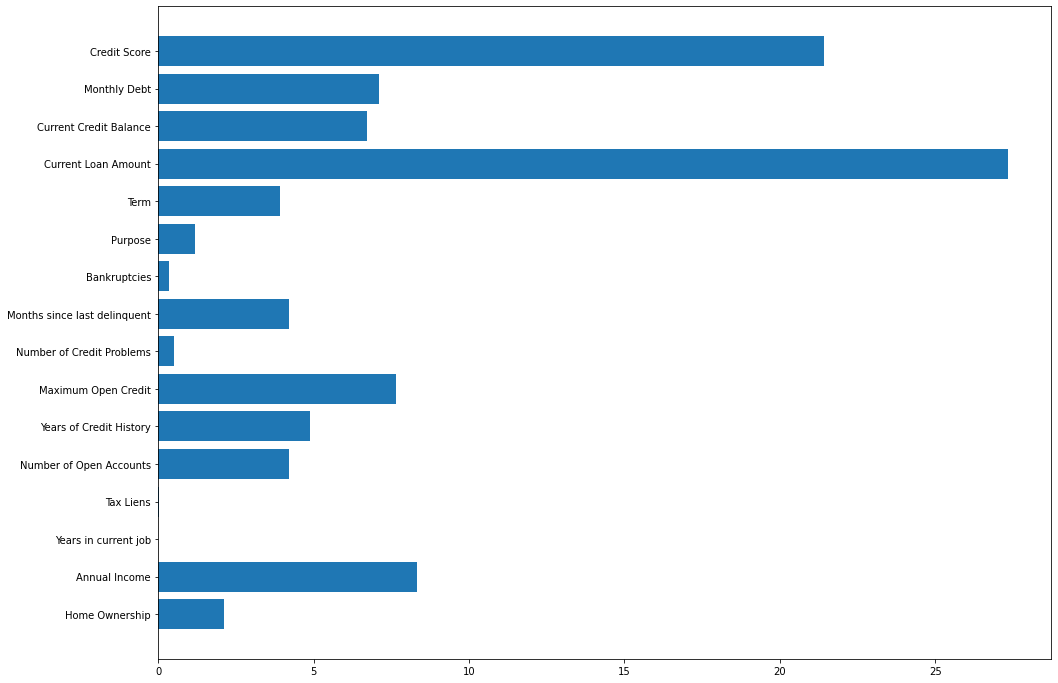

In [56]:
plt.barh(train_df.drop('Credit Default', axis=1).columns, model.get_feature_importance())

In [57]:
preds = model.predict(train_mod.drop('Credit Default', axis=1))
f1_sc = f1_score(train_mod['Credit Default'], preds)
p_score = precision_score(train_mod['Credit Default'], preds)
r_score = recall_score(train_mod['Credit Default'], preds)
print('F1-score: {:.3}\nWith precision = {:.3} and recall = {:.3}'.format(f1_sc, p_score, r_score))

F1-score: 0.644
With precision = 0.543 and recall = 0.789


##### Profit

In [58]:
test_mod = test_df.copy()
test_mod.loc[test_mod['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
test_mod['Years in current job'] = test_mod['Years in current job'].fillna('0').map({'0': 0, '< 1 year': 1, '1 year': 2, '2 years': 3,
                                                                                     '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, 
                                                                                     '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11})
test_mod.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = test_mod.loc[:, ['Months since last delinquent', 
                                                                                                     'Bankruptcies', 'Credit Score']].fillna(value=0)
test_mod['Annual Income'].fillna(value=train_mod['Annual Income'].mean(), inplace=True)
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [59]:
final_preds = model.predict(test_mod)

predicted_df = pd.DataFrame(final_preds, columns=['Credit Default'])
predicted_df.to_csv('predicted_defaults.csv', index_label='id')